In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tqdm import tqdm

import urllib
from urllib.error import HTTPError
from deap import tools

%matplotlib inline

# ES

In [2]:
def es(objective_function,
       chromosome_length,
       population_size, 
       number_of_iterations, 
       number_of_offspring, 
       number_of_parents, 
       sigma, 
       tau, 
       tau_0,
       log_frequency=1,
       mutation=None
):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
            
        parent_indices = np.random.choice(
            population_size,
            (number_of_offspring, number_of_parents),
            True,
            fitness_values
        ).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas \
                                        * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) \
                                        + tau_0 * np.random.randn(number_of_offspring, 1))
        
        children_population_solutions += children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([
            current_population_objective_values, 
            children_population_objective_values
        ])
        
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [
            current_population_objective_values.min(),
            current_population_objective_values.max(), 
            current_population_objective_values.mean(), 
            current_population_objective_values.std()
        ]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

In [3]:
def run_es(d, N, T, objective_function, log_every=10, sigma=50.0):
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
        objective_function, d, N, T, 2*N, 2, sigma, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), log_every)

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 0])
    plt.plot(history_objective_values[:, 1])
    plt.plot(history_objective_values[:, 2])
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.legend(['Min','Mean', 'Max'], loc='upper right')
    plt.show()

    plt.figure(figsize=(18, 4))
    plt.plot(history_best_sigmas)
    plt.xlabel('iteration')
    plt.ylabel('sigma value')
    plt.title('best sigmas')
    plt.show()

## Benchmark functions

In [4]:
# Sphere function (minimum at 0)
def objective_function_F1(X):
    return - np.sum(X**2, axis=1)

# Sphere function - modified
def objective_function_F1a(X):
    return - (X[:, 0]**2 + 9*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1b(X):
    return - (X[:, 0]**2 + 625*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1c(X):
    return - (X[:, 0]**2 + 2*X[:, 1]**2 - 2 * X[:, 0] * X[:, 1])


# Rastrigin function (minimum at 0)
def objective_function_F6(X):
    return - 10.0 * X.shape[1] - np.sum(X**2, axis=1) + 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)


# Schwefel function (minimum at 420.9687)
# (REMARK: should be considered only on [-500, 500]^d, because there are better minima outside)
def objective_function_F7(X):
    return - 418.9829 * X.shape[1] + np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)


# Griewank function (minimum at 0)
def objective_function_F8(X):
    return - 1 - np.sum(X**2 / 4000, axis=1) + np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[1], X.shape[1]))), axis=1)

In [5]:
def plot_3D_benchmark_function(objective_function, domain_X, domain_Y, title):
    plt.figure(figsize=(12, 8))
    ax = plt.gca(projection='3d')
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.hot, linewidth=0, antialiased=True)
    plt.title(title)
    plt.show()

In [6]:
def plot_contour_benchmark_function(objective_function, domain_X, domain_Y, title):
    plt.figure(figsize=(9, 9))
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    plt.contour(X, Y, Z, 50)
    plt.title(title)
    plt.show()

# 1. Sphere

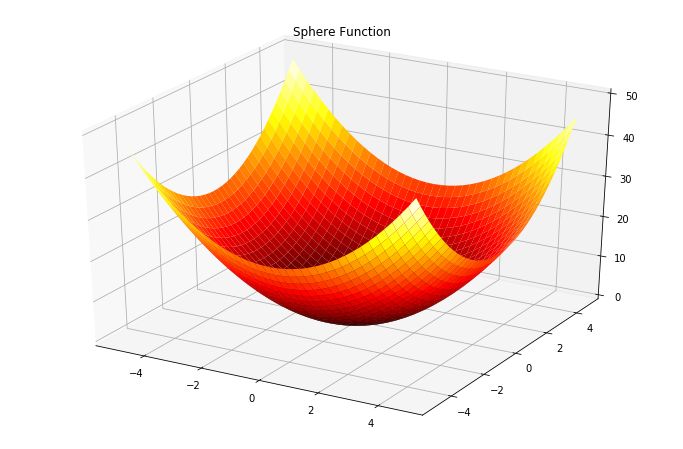

In [7]:
plot_3D_benchmark_function(objective_function_F1, np.arange(-5, 5, 0.25), np.arange(-5, 5, 0.25), 'Sphere Function')

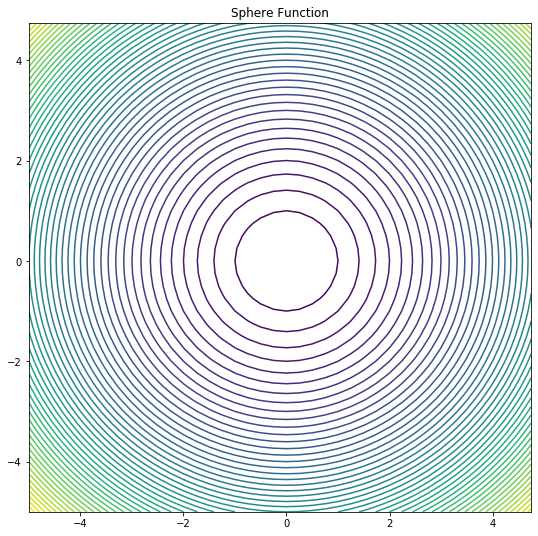

In [8]:
plot_contour_benchmark_function(objective_function_F1, np.arange(-5, 5, 0.25), np.arange(-5, 5, 0.25), 'Sphere Function')

## 1.1 d=10

Iteration 0000 : best score = -4741.76337986, mean score = -26628.45980824.
Iteration 0020 : best score = -0.08254142, mean score = -0.58837189.
Iteration 0040 : best score = -0.00000028, mean score = -0.00000250.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = -0.00000000, mean score = -0.00000000.


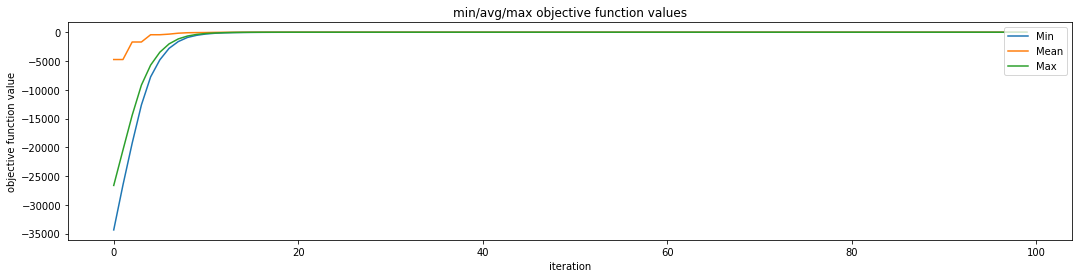

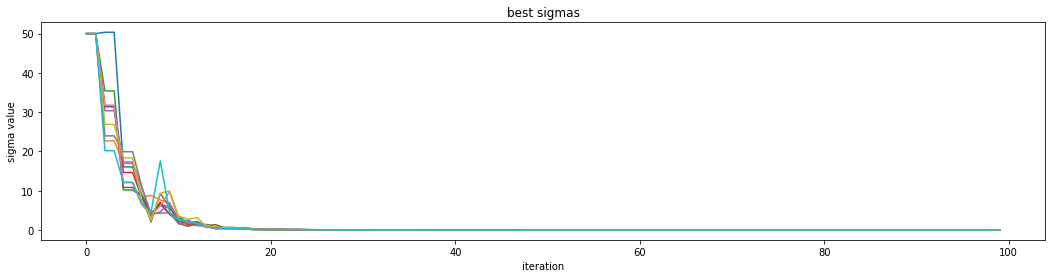

In [23]:
run_es(d=10, N=2000, T=100, objective_function=objective_function_F1, log_every=20)

## 1.2 d=20

Iteration 0000 : best score = -22335.58362926, mean score = -59462.72128861.
Iteration 0020 : best score = -19.17988955, mean score = -44.99543069.
Iteration 0040 : best score = -0.00911106, mean score = -0.02243572.
Iteration 0060 : best score = -0.00000529, mean score = -0.00001484.
Iteration 0080 : best score = -0.00000000, mean score = -0.00000001.


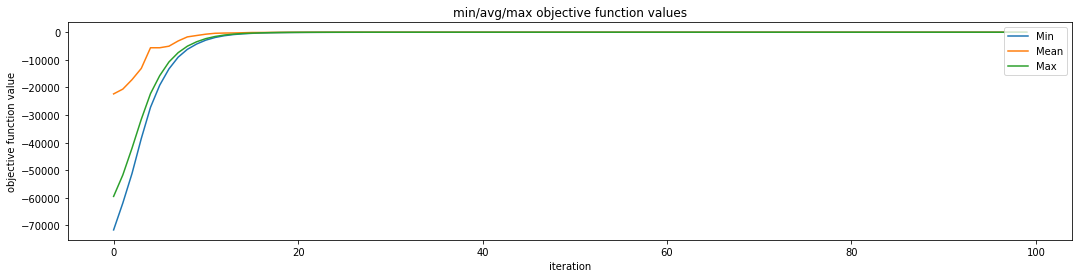

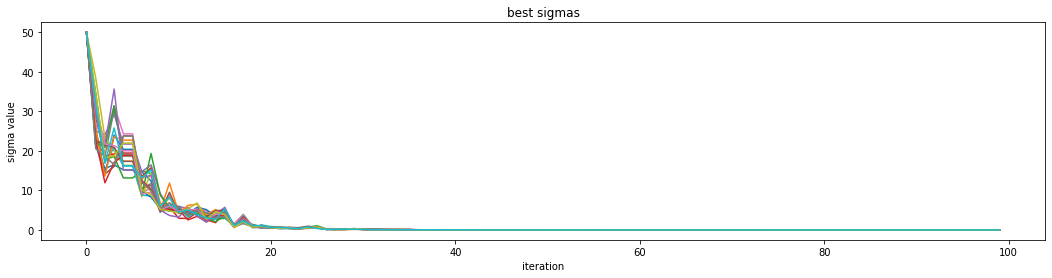

In [24]:
run_es(d=20, N=2000, T=100, objective_function=objective_function_F1, log_every=20)

## 1.3 d=50

Iteration 0000 : best score = -101889.96925495, mean score = -161254.41883728.
Iteration 0040 : best score = -211.00071647, mean score = -293.04344691.
Iteration 0080 : best score = -0.67993218, mean score = -0.99744103.
Iteration 0120 : best score = -0.00194670, mean score = -0.00258795.
Iteration 0160 : best score = -0.00000752, mean score = -0.00000998.


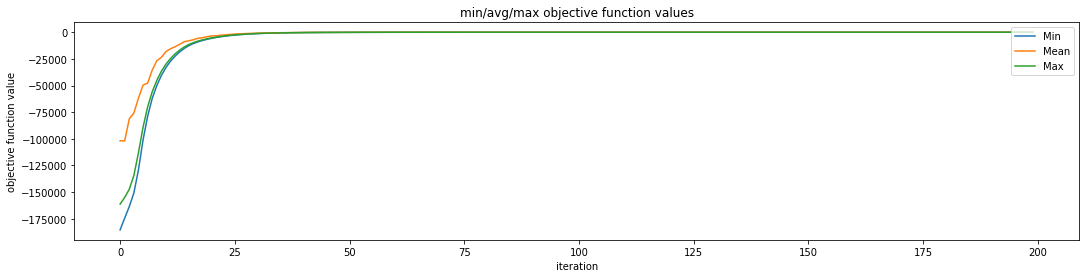

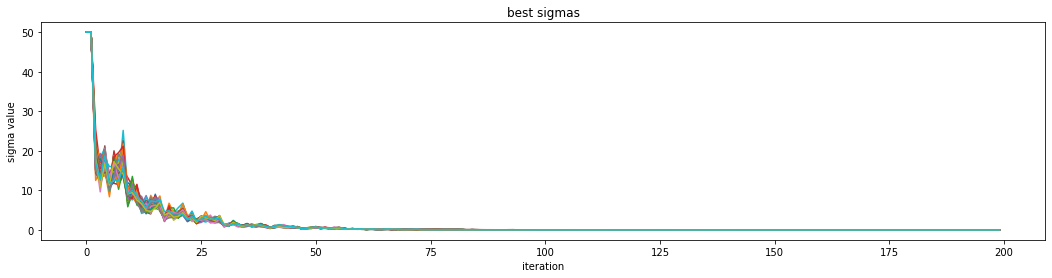

In [25]:
run_es(d=50, N=2000, T=200, objective_function=objective_function_F1, log_every=40)

## 1.4 d=100

Iteration 0000 : best score = -230051.51536897, mean score = -328738.45011429.
Iteration 0050 : best score = -4414.48817128, mean score = -5235.53581849.
Iteration 0100 : best score = -138.03482200, mean score = -163.01424748.
Iteration 0150 : best score = -4.06740144, mean score = -4.77908919.
Iteration 0200 : best score = -0.12879801, mean score = -0.15172370.
Iteration 0250 : best score = -0.00440548, mean score = -0.00516339.


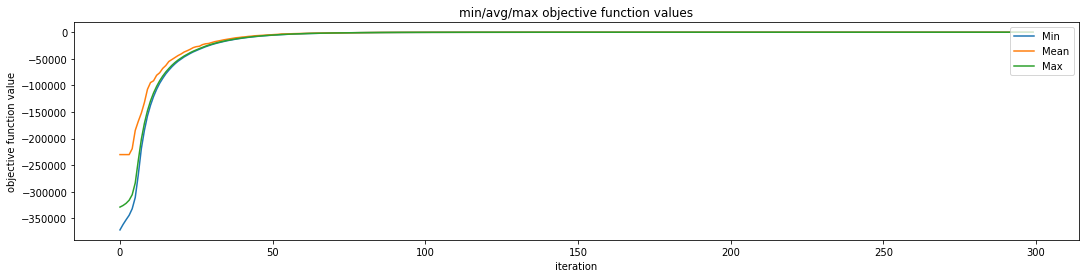

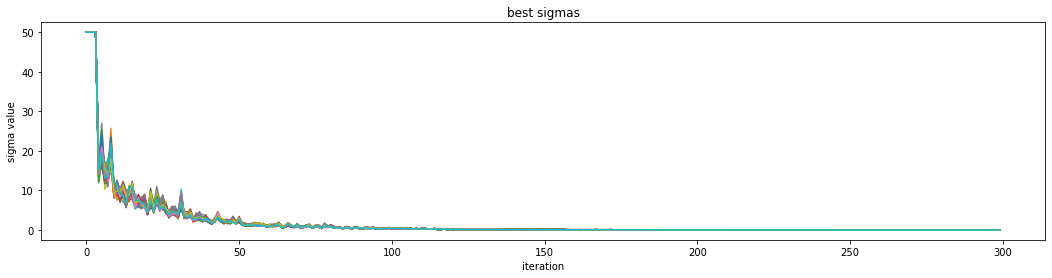

In [26]:
run_es(d=100, N=2000, T=300, objective_function=objective_function_F1, log_every=50)

# 2. Rastrigin

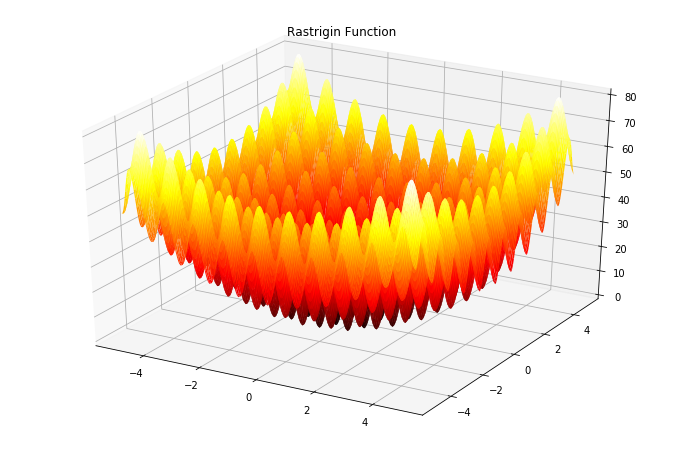

In [10]:
plot_3D_benchmark_function(objective_function_F6, np.arange(-5, 5, 0.05), np.arange(-5, 5, 0.05), 'Rastrigin Function')

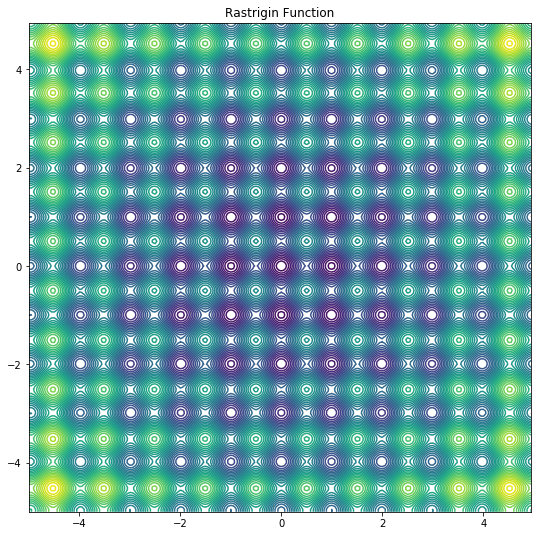

In [11]:
plot_contour_benchmark_function(objective_function_F6, np.arange(-5, 5, 0.05), np.arange(-5, 5, 0.05), 'Rastrigin Function')

## 2.1 d=10

Iteration 0000 : best score = -6364.69916005, mean score = -26840.16975464.
Iteration 0020 : best score = -33.87888149, mean score = -76.40761360.
Iteration 0040 : best score = -19.36114491, mean score = -55.72600230.
Iteration 0060 : best score = -11.98187951, mean score = -44.98880149.
Iteration 0080 : best score = -1.99020877, mean score = -1.99134813.


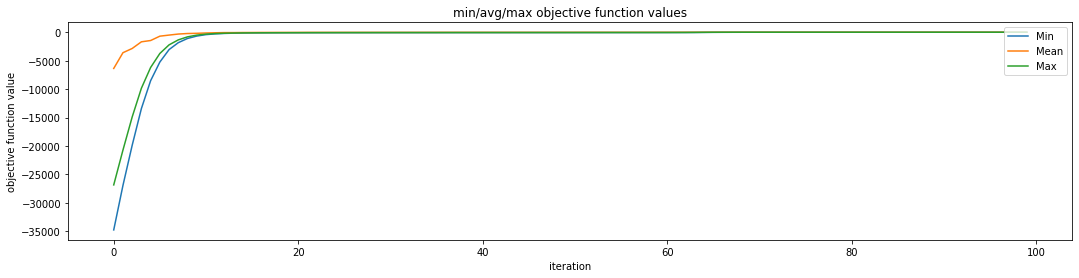

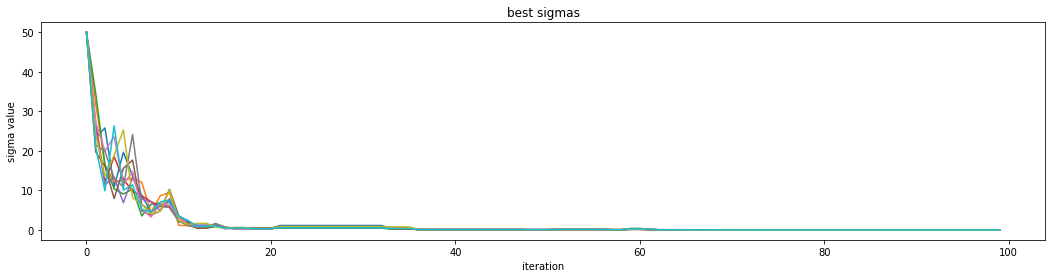

In [12]:
run_es(d=10, N=2000, T=100, objective_function=objective_function_F6, log_every=20)

## 2.2 d=20

Iteration 0000 : best score = -21576.80231819, mean score = -60009.86834955.
Iteration 0020 : best score = -136.73019631, mean score = -237.84780520.
Iteration 0040 : best score = -92.53373008, mean score = -153.62616783.
Iteration 0060 : best score = -63.37340280, mean score = -118.89897155.
Iteration 0080 : best score = -15.96889480, mean score = -16.05633507.
Iteration 0100 : best score = -15.91937613, mean score = -15.91941876.
Iteration 0120 : best score = -15.91934493, mean score = -15.91934497.
Iteration 0140 : best score = -15.91934491, mean score = -15.91934491.
Iteration 0160 : best score = -15.91934491, mean score = -15.91934491.
Iteration 0180 : best score = -15.91934491, mean score = -15.91934491.


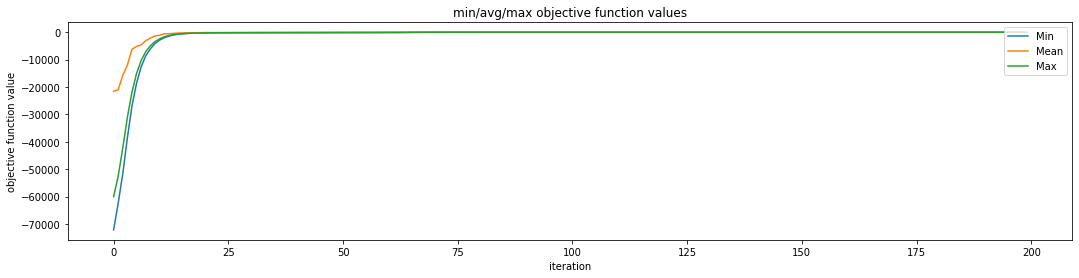

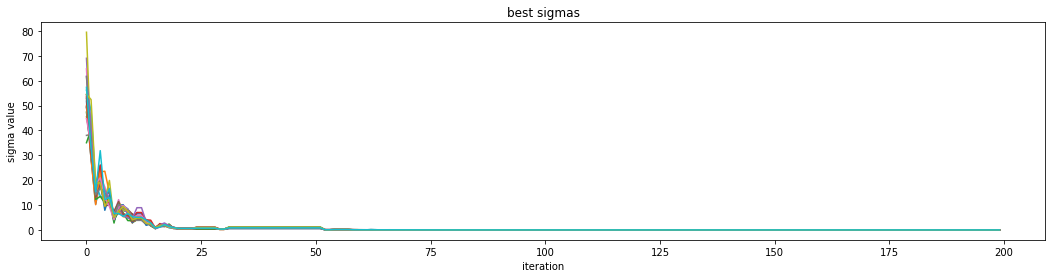

In [13]:
run_es(d=20, N=2000, T=200, objective_function=objective_function_F6, log_every=20)

## 2.3 d=50

Iteration 0000 : best score = -91786.49657874, mean score = -160609.32636116.
Iteration 0050 : best score = -479.41582833, mean score = -595.43965255.
Iteration 0100 : best score = -215.34261665, mean score = -265.91979788.
Iteration 0150 : best score = -87.62454569, mean score = -87.66170603.


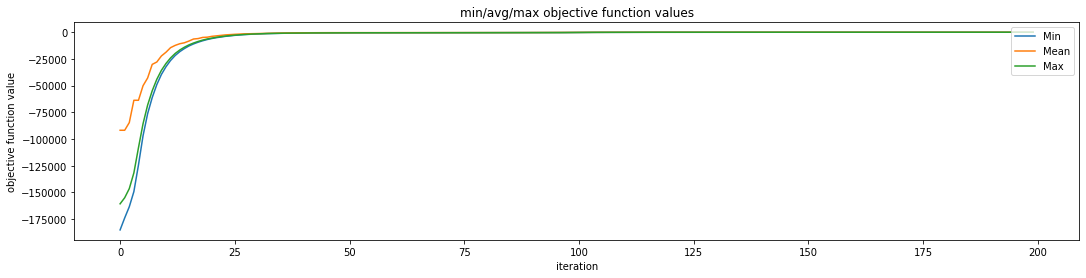

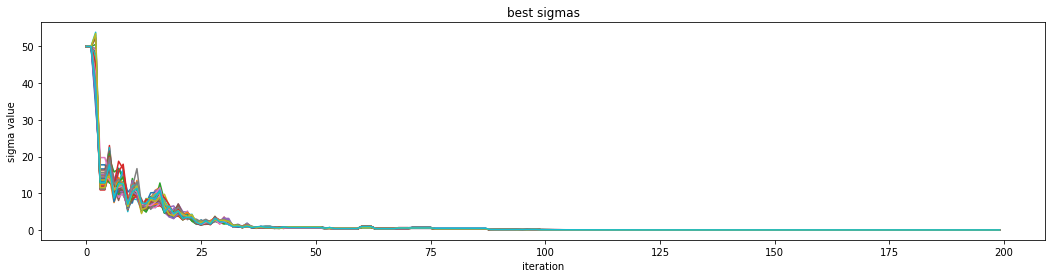

In [42]:
run_es(d=50, N=3000, T=200, objective_function=objective_function_F6, log_every=50)

## 2.4 d=100

Iteration 0000 : best score = -236391.12882024, mean score = -330747.23155565.
Iteration 0050 : best score = -4550.79325344, mean score = -5322.83527655.
Iteration 0100 : best score = -1183.72502676, mean score = -1350.78409009.
Iteration 0150 : best score = -604.42223109, mean score = -632.03215670.
Iteration 0200 : best score = -407.47613515, mean score = -410.13685940.
Iteration 0250 : best score = -380.46625165, mean score = -380.65586115.


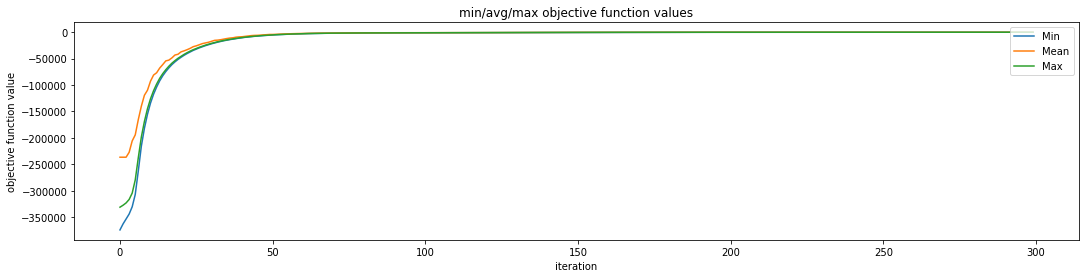

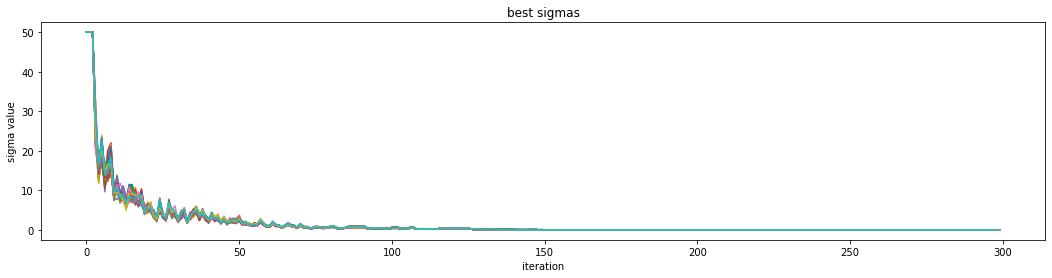

In [43]:
run_es(d=100, N=4000, T=300, objective_function=objective_function_F6, log_every=50)

# 3. Schwefel

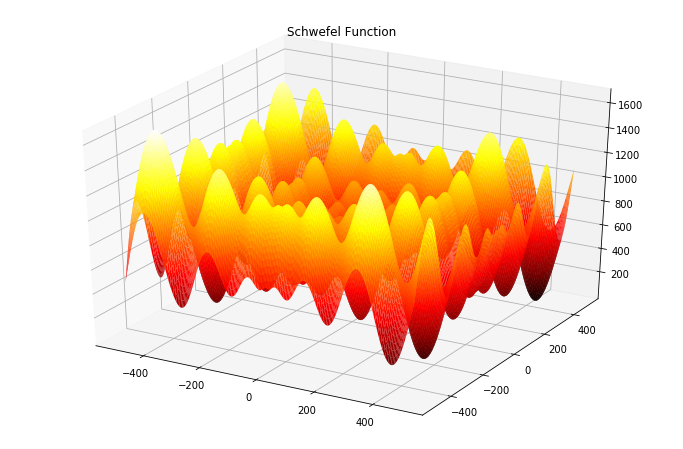

In [16]:
plot_3D_benchmark_function(objective_function_F7, np.arange(-500, 500, 5), np.arange(-500, 500, 5), 'Schwefel Function')

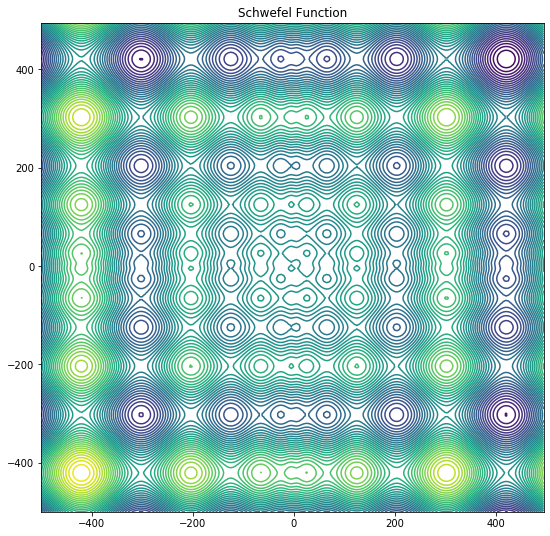

In [17]:
plot_contour_benchmark_function(objective_function_F7, np.arange(-500, 500, 5), np.arange(-500, 500, 5), 'Schwefel Function')

## 3.1 d=10

Iteration 0000 : best score = -3631.01361128, mean score = -3890.69948429.
Iteration 0020 : best score = -3553.47970674, mean score = -3553.48233292.
Iteration 0040 : best score = -3553.47918049, mean score = -3553.47918050.
Iteration 0060 : best score = -3553.47918048, mean score = -3553.47918048.
Iteration 0080 : best score = -3553.47918048, mean score = -3553.47918048.


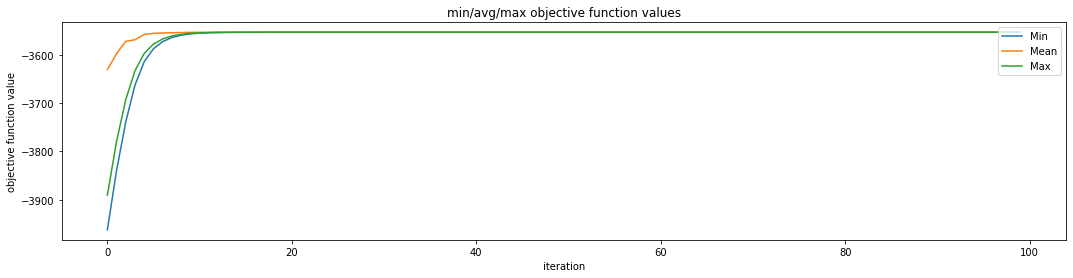

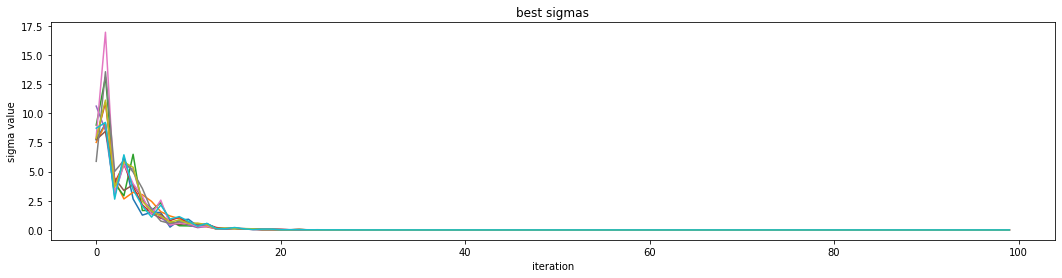

In [44]:
run_es(d=10, N=5000, T=100, objective_function=objective_function_F7, log_every=20, sigma=10)

## 3.2 d=20

Iteration 0000 : best score = -7440.06393122, mean score = -7844.31939835.
Iteration 0040 : best score = -7106.95844627, mean score = -7106.95863925.
Iteration 0080 : best score = -7106.95836097, mean score = -7106.95836097.
Iteration 0120 : best score = -7106.95836097, mean score = -7106.95836097.


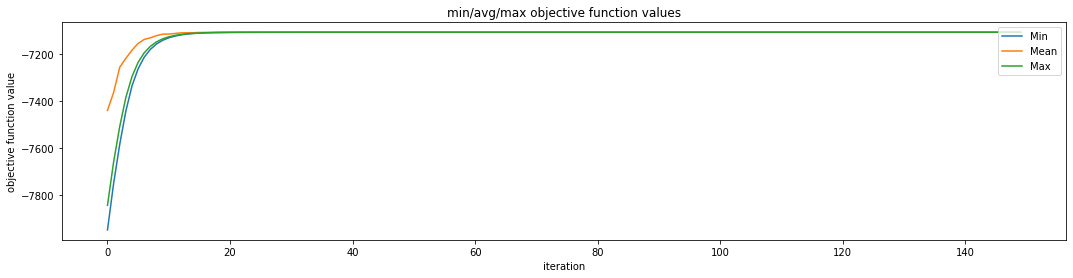

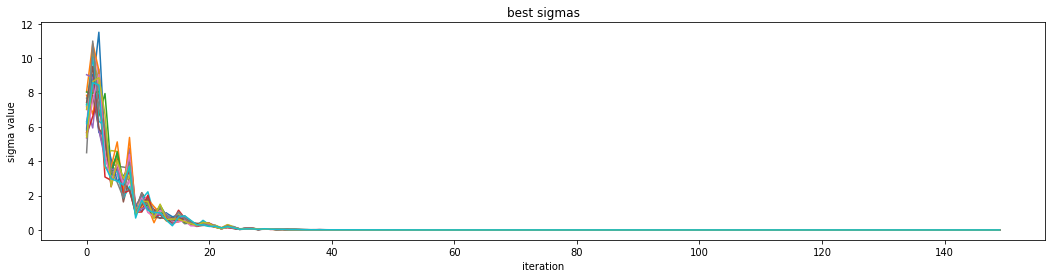

In [48]:
run_es(d=20, N=5000, T=150, objective_function=objective_function_F7, log_every=40, sigma=10)

## 3.3 d=50

Iteration 0000 : best score = -19103.54434612, mean score = -19751.03385652.
Iteration 0030 : best score = -17773.76894797, mean score = -17776.67019395.
Iteration 0060 : best score = -17767.47817799, mean score = -17767.51017244.
Iteration 0090 : best score = -17767.39696207, mean score = -17767.39737371.
Iteration 0120 : best score = -17767.39591248, mean score = -17767.39591952.


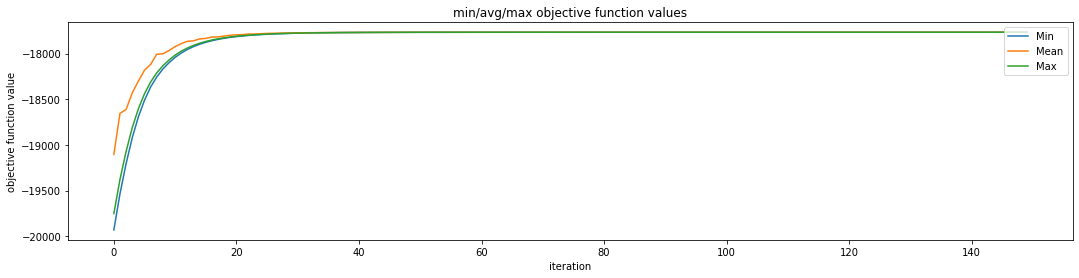

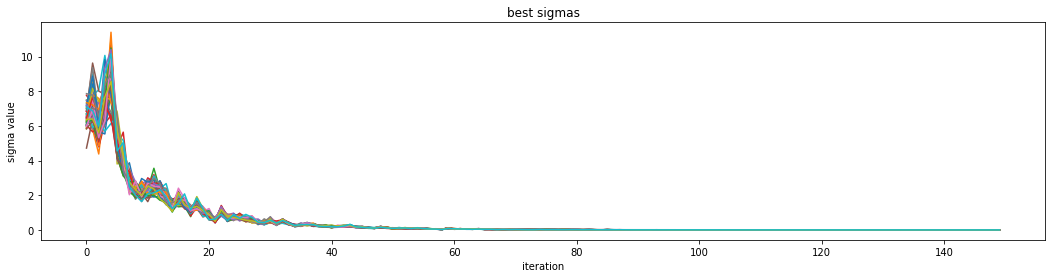

In [49]:
run_es(d=50, N=5000, T=150, objective_function=objective_function_F7, log_every=30, sigma=10)

## 3.4 d=100

Iteration 0000 : best score = -38648.71343230, mean score = -39604.64771526.
Iteration 0030 : best score = -35668.63969563, mean score = -35700.25252068.
Iteration 0060 : best score = -35548.73383441, mean score = -35551.39783122.
Iteration 0090 : best score = -35536.27499038, mean score = -35536.59423147.
Iteration 0120 : best score = -35534.95979529, mean score = -35534.99718285.


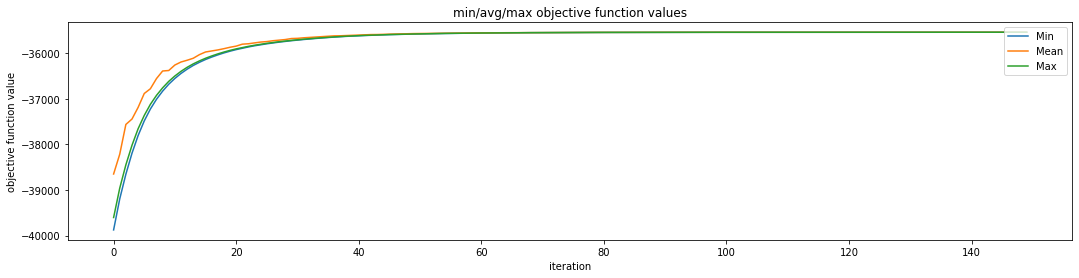

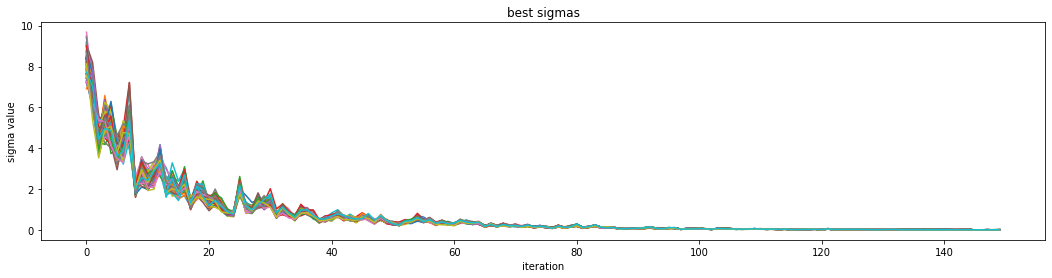

In [50]:
run_es(d=100, N=5000, T=150, objective_function=objective_function_F7, log_every=30, sigma=10)

# 4. Griewank

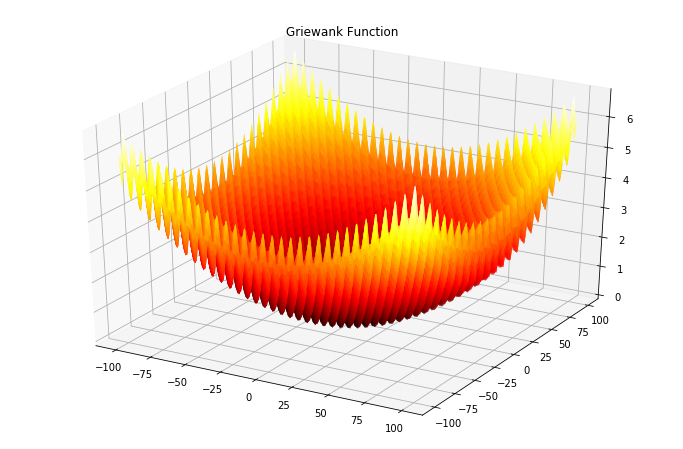

In [18]:
plot_3D_benchmark_function(objective_function_F8, np.arange(-100, 100, 0.5), np.arange(-100, 100, 0.5), 'Griewank Function')

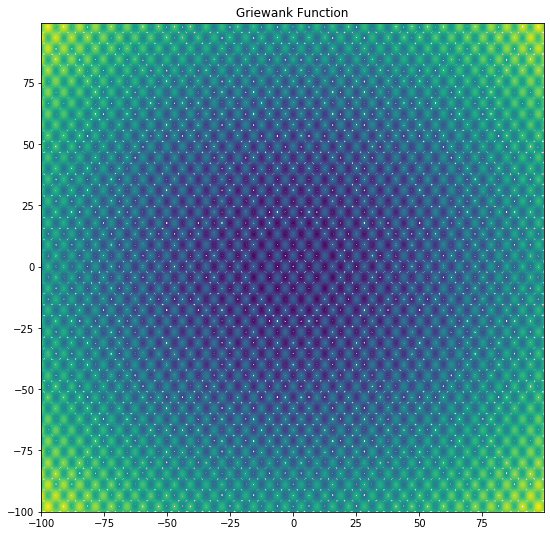

In [19]:
plot_contour_benchmark_function(objective_function_F8, np.arange(-100, 100, 0.5), np.arange(-100, 100, 0.5), 'Griewank Function')

## 4.1 d=10

Iteration 0000 : best score = -2.12428183, mean score = -6.18644574.
Iteration 0020 : best score = -0.09427827, mean score = -0.59865670.
Iteration 0040 : best score = -0.00000200, mean score = -0.00001664.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = 0.00000000, mean score = -0.00000000.


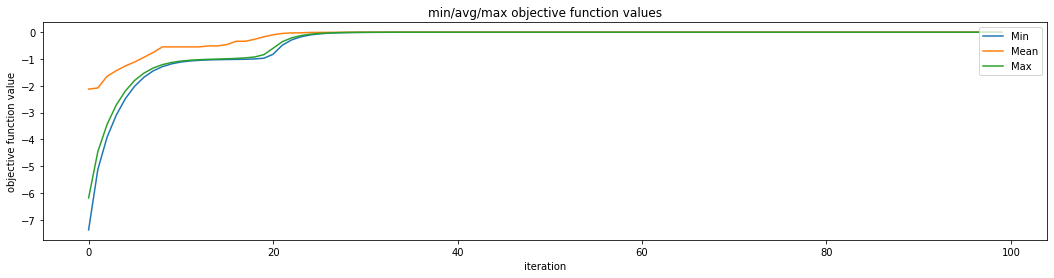

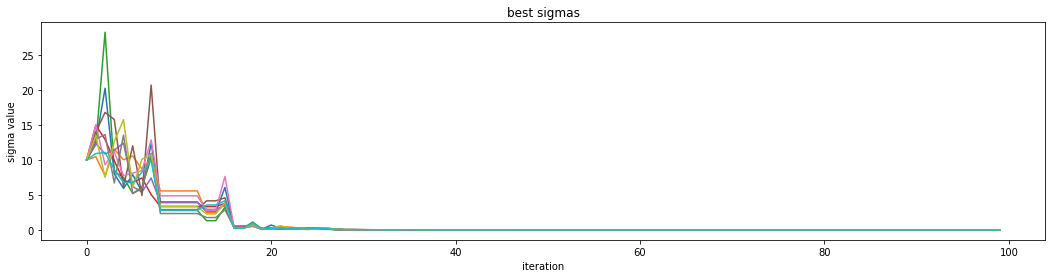

In [51]:
run_es(d=10, N=5000, T=100, objective_function=objective_function_F8, log_every=20, sigma=10)

## 4.2 d=20

Iteration 0000 : best score = -6.67788765, mean score = -12.96275877.
Iteration 0020 : best score = -0.93847701, mean score = -1.02718417.
Iteration 0040 : best score = -0.01567693, mean score = -0.02489595.
Iteration 0060 : best score = -0.00747379, mean score = -0.00756227.
Iteration 0080 : best score = -0.00739625, mean score = -0.00739661.


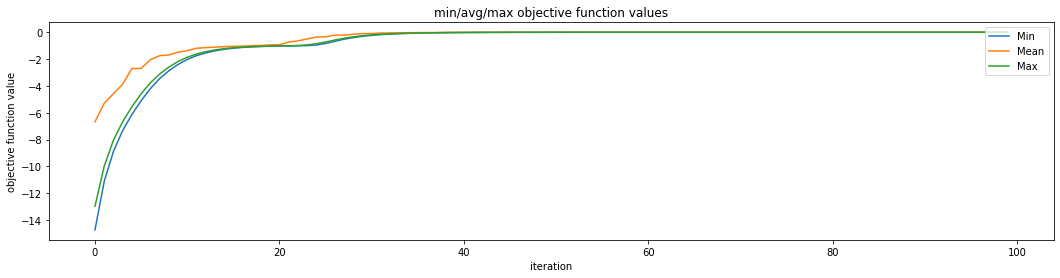

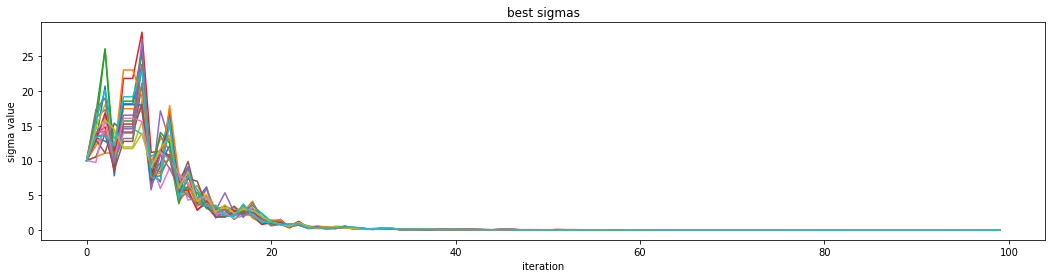

In [53]:
run_es(d=20, N=5000, T=100, objective_function=objective_function_F8, log_every=20, sigma=10)

## 4.3 d=50

Iteration 0000 : best score = -23.03127405, mean score = -33.92085265.
Iteration 0020 : best score = -2.33495884, mean score = -3.03369014.
Iteration 0040 : best score = -1.06422038, mean score = -1.09878084.
Iteration 0060 : best score = -0.44811485, mean score = -0.53315307.
Iteration 0080 : best score = -0.13953320, mean score = -0.16409662.


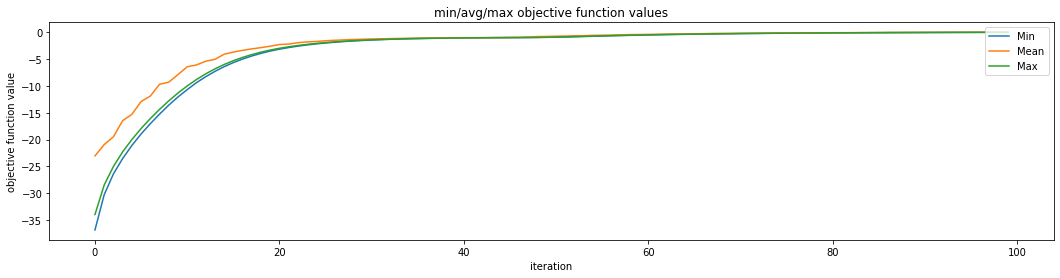

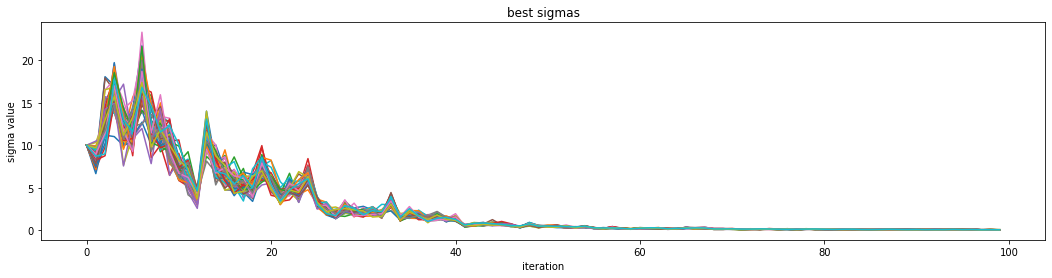

In [54]:
run_es(d=50, N=5000, T=100, objective_function=objective_function_F8, log_every=20, sigma=10)

## 4.4 d=100

Iteration 0000 : best score = -54.81514385, mean score = -69.70478520.
Iteration 0020 : best score = -13.18415552, mean score = -15.81007524.
Iteration 0040 : best score = -3.61408745, mean score = -4.19982084.
Iteration 0060 : best score = -1.61403647, mean score = -1.73463405.
Iteration 0080 : best score = -1.13892286, mean score = -1.17064714.


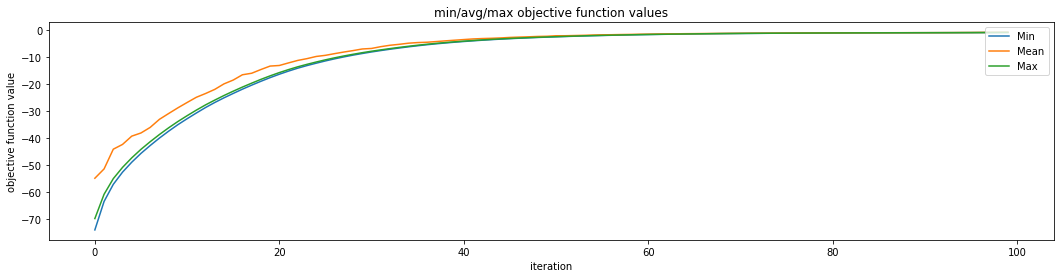

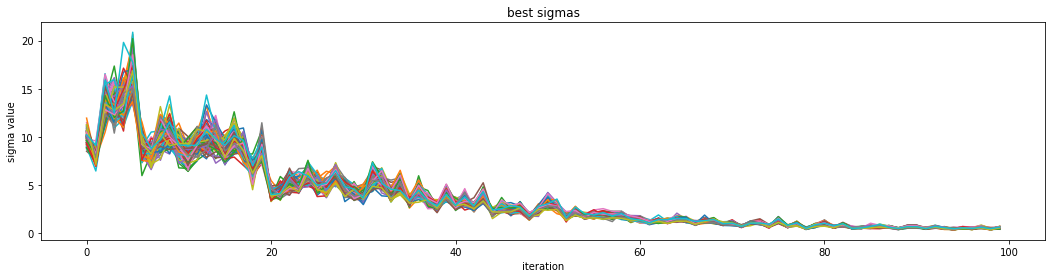

In [55]:
run_es(d=100, N=5000, T=100, objective_function=objective_function_F8, log_every=20, sigma=10)